In [1]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as Img

import os
import numpy as np

from scipy import ndimage as ndi
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg

import skimage
from skimage import filters, morphology, measure, data, img_as_float
from skimage.measure import label, regionprops
from skimage.morphology import watershed, closing, square, reconstruction, skeletonize, medial_axis
from skimage.morphology import remove_small_objects, disk, rectangle, square, binary_dilation, binary_erosion
from skimage.morphology import convex_hull_image
from skimage.feature import canny, corner_harris, corner_subpix, corner_peaks
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.color import label2rgb
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse, line, line_aa

# Чтение изображения

In [2]:
target_folder = 'training/'
pict_name = '002.tif'
filename = target_folder + pict_name

In [3]:
def load_image(infilename):
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img)
    img.close()
    return data.copy()

In [4]:
def save_image(image, ofilename):
    im = Image.fromarray(image)
    im.save(ofilename)

In [5]:
def convert_to_jpg():
    for filename in os.listdir('training'):
        filename = 'training/' + filename
        save_image(load_image(filename), filename[:-4] + '.jpg')

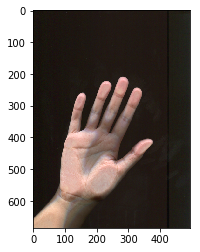

In [6]:
image = load_image(filename)
plt.imshow(image)
#plt.savefig('hand_origin.jpg')

# Бинаризация

(0, 255)

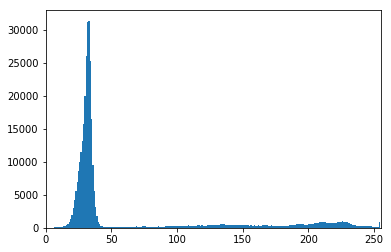

In [7]:
red_channel = image[:, :, 0]
red_hist, red_bin_edges = np.histogram(red_channel, bins=range(256))
plt.bar(red_bin_edges[:-1], red_hist, width = 1)
plt.xlim(min(red_bin_edges), max(red_bin_edges))
#plt.savefig('histogram2.pdf')

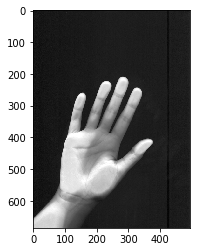

In [8]:
red_channel = image[:, :, 0]
plt.imshow(red_channel, cmap='gray')
#plt.savefig('red_channel_1.jpg')

### Определяем границы гауссианы

In [9]:
gauss_range = 20

In [10]:
mode = np.argmax(red_hist)
mode

33

In [11]:
red_hist[mode - gauss_range:mode + gauss_range]

array([  190,   218,   292,   350,   513,   830,  1288,  1950,  2992,
        4141,  5506,  6984,  8602, 10048, 11555, 13155, 15692, 20024,
       25992, 31274, 31409, 25362, 16562,  9588,  5560,  3163,  1758,
         889,   557,   329,   233,   184,   139,   149,   134,   127,
         138,   151,   154,   140])

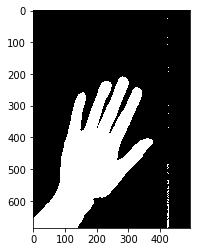

In [12]:
mask = (red_channel >= mode - gauss_range) & (red_channel <= mode + gauss_range)
full_binary_im = np.zeros_like(red_channel)
full_binary_im[~mask] = 255
plt.imshow(full_binary_im, cmap='gray')
#plt.savefig('binarization_5.jpg')

# Очистка от шумов

In [13]:
binary_im = full_binary_im / 255

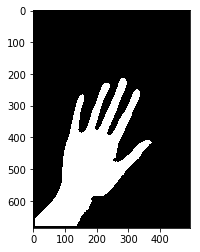

In [14]:
binary_im = morphology.binary_erosion(binary_im, selem=morphology.disk(6))
plt.imshow(binary_im, cmap='gray')

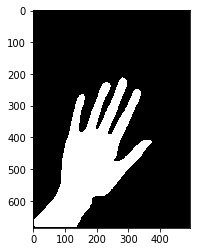

In [15]:
binary_im = morphology.binary_dilation(binary_im, selem=morphology.disk(2))
plt.imshow(binary_im, cmap='gray')

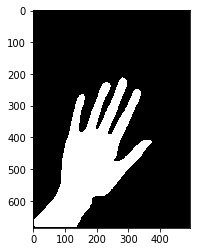

In [16]:
binary_im = ndi.binary_fill_holes(binary_im)
plt.imshow(binary_im, cmap='gray')

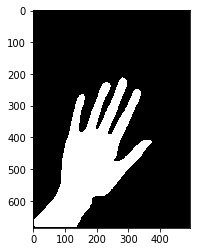

In [17]:
label_image = label(binary_im)
max_area = 0
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    box_area = (maxr - minr) * (maxc - minc)
    if box_area > max_area:
        max_area = box_area

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    box_area = (maxr - minr) * (maxc - minc)
    if box_area < max_area:
        binary_im[minr:maxr, minc:maxc] = 0
plt.imshow(binary_im, cmap='gray')
#plt.savefig('hand.jpg')

# Построение скелета

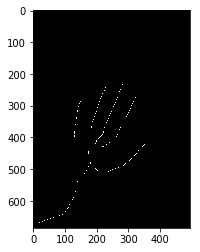

In [18]:
skeleton = skeletonize(binary_im)
plt.imshow(skeleton, cmap='gray')
#plt.savefig('skeleton.jpg')

In [19]:
%%time
radius_map = np.zeros_like(skeleton, dtype='float')
for radius in range(1, 36):
    print('radius:', radius)
    dilated_skeleton = morphology.binary_dilation(skeleton, selem=morphology.disk(radius))
    dilated_skeleton[binary_im == 0] = 0
    dilated_skeleton = morphology.binary_erosion(dilated_skeleton, selem=morphology.disk(radius))
    radius_map[dilated_skeleton] = radius

radius: 1
radius: 2
radius: 3
radius: 4
radius: 5
radius: 6
radius: 7
radius: 8
radius: 9
radius: 10
radius: 11
radius: 12
radius: 13
radius: 14
radius: 15
radius: 16
radius: 17
radius: 18
radius: 19
radius: 20
radius: 21
radius: 22
radius: 23
radius: 24
radius: 25
radius: 26
radius: 27
radius: 28
radius: 29
radius: 30
radius: 31
radius: 32
radius: 33
radius: 34
radius: 35
CPU times: user 47.8 s, sys: 1.69 s, total: 49.5 s
Wall time: 49.5 s


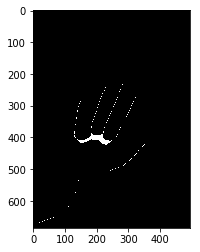

In [20]:
new_map = (radius_map > 0) & (radius_map < 35)
plt.imshow(new_map, cmap='gray')
#plt.savefig('mask2.jpg')

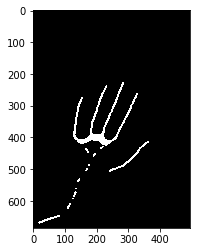

In [21]:
new_map = morphology.binary_dilation(new_map, selem=morphology.disk(3))
plt.imshow(new_map, cmap='gray')

In [22]:
label_image = label(new_map)
areas = []
max_area_1 = 0
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    box_area = (maxr - minr) * (maxc - minc)
    areas.append(box_area)

In [23]:
areas = list(reversed(sorted(areas)))
print(areas)

[41410, 12416, 1988, 266, 221, 198, 180, 180, 180, 99, 49, 49, 49]


In [24]:
least_id = min(1, len(areas) - 1)
if (len(areas) > 1) & (areas[2] > 5000):
    least_id = 2

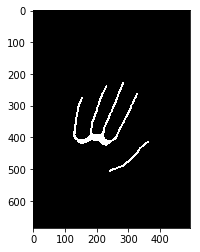

In [25]:
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    box_area = (maxr - minr) * (maxc - minc)
    if box_area == areas[0]:
        main_fingers_map = np.zeros_like(new_map)
        main_fingers_map[minr:maxr, minc:maxc] = new_map[minr:maxr, minc:maxc]
    elif box_area == areas[1]:
        big_finger_map = np.zeros_like(new_map)
        big_finger_map[minr:maxr, minc:maxc] = new_map[minr:maxr, minc:maxc]
    elif box_area < areas[least_id]:
        new_map[minr:maxr, minc:maxc] = 0
plt.imshow(new_map, cmap='gray')
#plt.savefig('mask3.jpg')

In [26]:
radius = 5
min_sum = float('inf')
for i in range(new_map.shape[0]):
    for j in range(new_map.shape[1]):
        if new_map[i, j] == 0:
            continue
        cur_sum = new_map[i-radius:i+radius+1, j-radius:j+radius+1].sum()
        if cur_sum < min_sum:
            min_sum = cur_sum
print(min_sum)

32


In [27]:
corners_y = []
corners_x = []
sum_val = []
for i in range(new_map.shape[0]):
    for j in range(new_map.shape[1]):
        if new_map[i, j] == 0:
            continue
        cur_sum = new_map[i-radius:i+radius+1, j-radius:j+radius+1].sum()
        if cur_sum <= min_sum + 30:
            corners_y.append(i)
            corners_x.append(j)
            sum_val.append(cur_sum)
corners_y = np.array(corners_y)
corners_x = np.array(corners_x)
sum_val = np.array(sum_val)

In [28]:
arg = np.argsort(sum_val)
sum_val = sum_val[arg]
corners_y = corners_y[arg]
corners_x = corners_x[arg]

In [29]:
map_of_added = np.zeros_like(new_map)
added_y = []
added_x = []
for i in range(sum_val.size):
    if map_of_added[corners_y[i], corners_x[i]] == 0:
        added_y.append(corners_y[i])
        added_x.append(corners_x[i])
        j = corners_y[i]
        k = corners_x[i]
        rad = 40
        target_shape = map_of_added[j-rad:j+rad+1, k-rad:k+rad+1].shape
        map_of_added[j-rad:j+rad+1, k-rad:k+rad+1] = morphology.rectangle(*target_shape)
added_y = np.array(added_y)
added_x = np.array(added_x)
len(added_x)

18

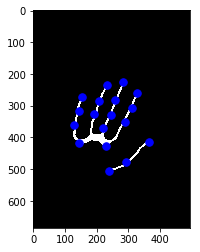

In [30]:
plt.imshow(new_map, cmap='gray')
plt.plot(added_x, added_y, '.b', markersize=15)
#plt.savefig('mask4.jpg')

# Выделение кончиков пальцев и перепонок

In [31]:
main_tips_y = []
main_tips_x = []
big_tip_y = []
big_tip_x = []
for i in range(added_x.size):
    j = added_y[i]
    k = added_x[i]
    tmp_map = new_map.copy()
    rad = 20
    tmp_map[j-rad:j+rad+1, k-rad:k+rad+1] = 0
    if len(regionprops(label(tmp_map))) == 2:
        if main_fingers_map[j, k] == 1:
            main_tips_y.append(j)
            main_tips_x.append(k)
        else:
            big_tip_y.append(j)
            big_tip_x.append(k)
print(len(main_tips_x), len(big_tip_x))

4 2


In [32]:
matr_main_tips = np.array([main_tips_x, main_tips_y]).T
matr_big_tips = np.array([big_tip_x, big_tip_y]).T
dist = cdist(matr_main_tips, matr_big_tips)
if dist.shape[0] < 2 or dist.shape[1] != 2:
    raise ValueError('I can\'t go any further')
ind = np.unravel_index(np.argmin(dist), dist.shape)
ind

(2, 0)

In [33]:
big_valey_y = big_tip_y[1 - ind[1]]
big_valey_x = big_tip_x[1 - ind[1]]
big_tip_y = big_tip_y[ind[1]]
big_tip_x = big_tip_x[ind[1]]

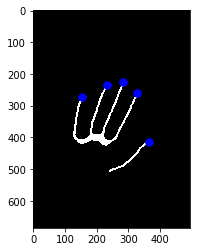

In [34]:
plt.imshow(new_map, cmap='gray')
plt.plot(main_tips_x, main_tips_y, '.b', markersize=15)
plt.plot(big_tip_x, big_tip_y, '.b', markersize=15)
#plt.savefig('mask5.jpg')

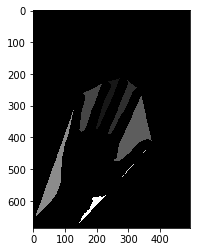

In [35]:
chull = convex_hull_image(binary_im)
chull[binary_im] = 0
chull = binary_erosion(chull, selem=disk(1))
chull = label(chull)
plt.imshow(chull, cmap='gray')
#plt.savefig('mask6.jpg')

In [36]:
def find_valey(a, b):
    middle = (a + b) / 2
    middle[0, 1], middle[0, 0] = middle[0, 0], middle[0, 1]
    ind = np.where(chull == chull[int(middle[0, 0]), int(middle[0, 1])])
    dist = cdist(middle, np.array(ind).T)
    i = dist[0].argmax()
    a = a[0]
    c = (ind[1][i], ind[0][i])
    rr, cc = line(a[1], a[0], c[1], c[0])
    for i in range(-3, 4):
        for j in range(-3, 4):
            image[:, :, 1][rr + i, cc + j] = 255
    rr, cc = line(b[1], b[0], c[1], c[0])
    for i in range(-3, 4):
        for j in range(-3, 4):
            image[:, :, 1][rr + i, cc + j] = 255
    rad = 10
    tmp_r = image[a[1]-rad:a[1]+rad+1, a[0]-rad:a[0]+rad+1, 0]
    tmp_r[np.where(disk(rad))] = 255
    tmp_g = image[a[1]-rad:a[1]+rad+1, a[0]-rad:a[0]+rad+1, 1]
    tmp_g[np.where(disk(rad))] = 0
    tmp_b = image[a[1]-rad:a[1]+rad+1, a[0]-rad:a[0]+rad+1, 2]
    tmp_b[np.where(disk(rad))] = 0

    tmp_r = image[b[1]-rad:b[1]+rad+1, b[0]-rad:b[0]+rad+1, 0]
    tmp_r[np.where(disk(rad))] = 255
    tmp_g = image[b[1]-rad:b[1]+rad+1, b[0]-rad:b[0]+rad+1, 1]
    tmp_g[np.where(disk(rad))] = 0
    tmp_b = image[b[1]-rad:b[1]+rad+1, b[0]-rad:b[0]+rad+1, 2]
    tmp_b[np.where(disk(rad))] = 0

    tmp_r = image[c[1]-rad:c[1]+rad+1, c[0]-rad:c[0]+rad+1, 0]
    tmp_r[np.where(disk(rad))] = 0
    tmp_g = image[c[1]-rad:c[1]+rad+1, c[0]-rad:c[0]+rad+1, 1]
    tmp_g[np.where(disk(rad))] = 0
    tmp_b = image[c[1]-rad:c[1]+rad+1, c[0]-rad:c[0]+rad+1, 2]
    tmp_b[np.where(disk(rad))] = 255
    return (ind[0][i], ind[1][i])

In [37]:
tip_a_matr = np.array([big_tip_x, big_tip_y])[np.newaxis, :]
tips_x = [big_tip_x]
tips_y = [big_tip_y]
valeys_x = []
valeys_y = []
while len(matr_main_tips) > 0:
    dist = cdist(tip_a_matr, matr_main_tips)
    ind = np.unravel_index(np.argmin(dist), dist.shape)[1]
    tip_b = matr_main_tips[ind]
    tips_x.append(tip_b[0])
    tips_y.append(tip_b[1])
    matr_main_tips = np.delete(matr_main_tips, ind, axis=0).reshape(-1, 2)
    valey = find_valey(tip_a_matr, tip_b)
    valeys_x.append(valey[0])
    valeys_y.append(valey[1])
    tip_a_matr = tip_b[np.newaxis, :]

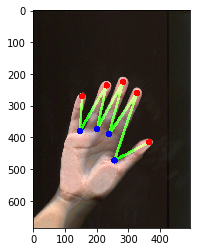

In [40]:
plt.imshow(image)
plt.savefig('res.jpg')

In [39]:
save_image(image, 'res_' + pict_name)